In [3]:
%load_ext autoreload
%autoreload 2

from src.racetrack import RaceTrack, tiny_course, big_course
from src.montecarlo import MonteCarloControl
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running the code you've made

Let's collect episodes where we behave using $\epsilon$-greedy policy and update a greedy policy using weighted importance sampling. 

We will use the code you wrote, and try to solve a small racecourse.  We will collect information about the behavior policy during learning, and at the end of learning we will collect a single episode per learner of the greedy target policy

Be warned, running this took 8 minutes using my code solution on a 2019 Macbook 2.4 GHz 8 core i9 operating in a conda COGS188Wi25 environment. Obviously YMMV according to your code's efficiency and the hardware/system setup.

In [2]:
random.seed(619) # replicability 

steps = []
behavior_rewards = []
target_rewards = []
for j in tqdm(range(20)):
    MC = MonteCarloControl(RaceTrack(tiny_course), max_episode_size=250)
    this_steps = []
    this_rewards = []
    for k in range(2000):
        episode = MC.generate_egreedy_episode()
        this_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )
        this_steps.append(len(episode))
        MC.update_offpolicy(episode)
    steps.append(this_steps)
    behavior_rewards.append(this_rewards)
    episode = MC.generate_greedy_episode()
    target_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )


100%|██████████| 20/20 [06:59<00:00, 20.96s/it]


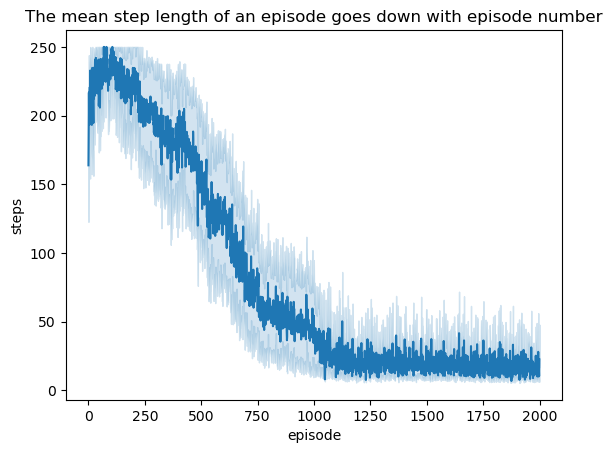

Whelp at least there is some indication of learning


In [3]:

df1 = pd.DataFrame(steps)
df1.columns.name = 'episode'
df1.index.name = 'learner'
df1 = df1.stack().rename('steps').to_frame()

sns.lineplot( data=df1, x='episode', y='steps');
plt.title('The mean step length of an episode goes down with episode number')
plt.show()
print('Welp at least there is some indication of learning')


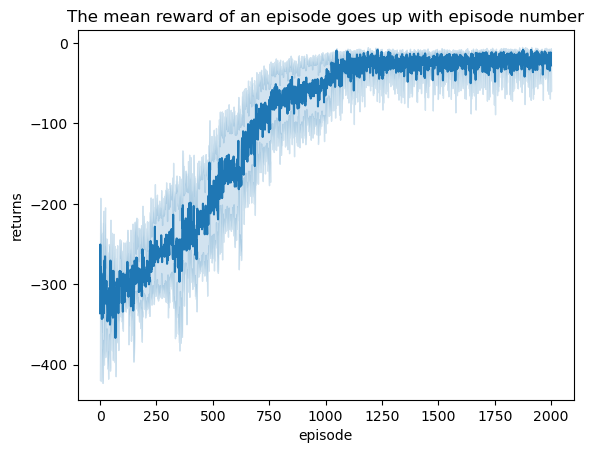

Whelp at least there is some indication of learning


In [4]:

df2 = pd.DataFrame(behavior_rewards)
df2.columns.name = 'episode'
df2.index.name = 'learner'
df2 = df2.stack().rename('returns').to_frame()


df3 = pd.DataFrame(target_rewards)
df3.columns.name = 'episode'
df3.index.name = 'learner'
df3 = df3.stack().rename('returns').to_frame()

sns.lineplot( data=df2, x='episode', y='returns');
plt.title('The mean reward of an episode goes up with episode number')
plt.show()
print('Welp at least there is some indication of learning')

                returns                  
                    min median max    IQR
condition                                
behavior policy    -314  -17.0  -3  60.50
target policy      -250   -8.0  -3  21.75


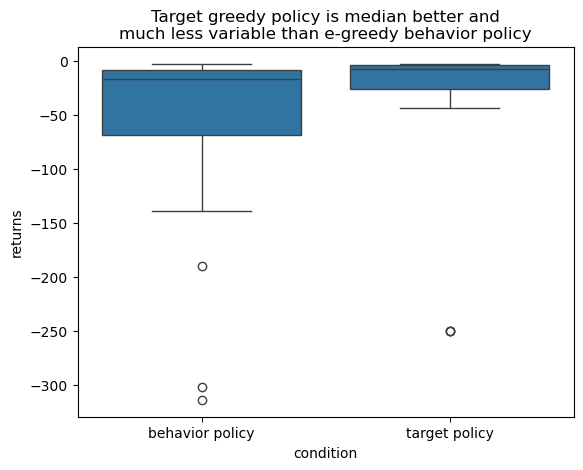

We can also see that (at least at the current number of episodes) even greedy sometimes is still failing hard


In [5]:
c1 = df2.query('episode==999').reset_index().drop(columns=['episode'])
c1['condition']='behavior policy'
c2 = df3.droplevel('episode').reset_index()
c2['condition']='target policy'

compare = pd.concat( [c1, c2], ignore_index=True)
sns.boxplot(data=compare, x='condition', y='returns');
plt.title('Target greedy policy is median better and\nmuch less variable than e-greedy behavior policy');


def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

stats_list = [
    'min', 'median', 'max', IQR  
]

print(compare.drop(columns=['learner']).groupby('condition').agg(stats_list))
plt.show()
print('We can also see that (at least at the current number of episodes) even greedy sometimes is still failing hard')

# Try the bigger course
Lets just run the bigger racecourse for longer because we know this is going to take longer to learn due to the larger state space.  At first I tried single runs out to >20k episodes and it still wasn't working until I tried a trick...

A Q0=-50 is helpful because it encourages the system to learn more quickly... Any return that is better than 50 moves looks like a real good deal! This is the opposite of a positive Q0 that encourages exploration, here we ask the MC to lock in quickly and exploit as soon as it finds a somewhat OK solution.  With that mod in place we finally get reasonable learning in reasonable time.  Without it (feel free to try!) I just ran out of patience and time.

But note that while we've found an OK solution already, its likely that a much better unfound solution still exists, and would obviously take >>20k episodes to learn with this kind of e-greedy exploration to randomly find this better solution

Be warned even with this trick this run took 9 minutes to run on my Macbook. 



In [24]:
random.seed(42) # replicability 

steps = []
behavior_rewards = []
target_rewards = []
for j in tqdm(range(20)):
    MC = MonteCarloControl(RaceTrack(big_course), max_episode_size=500, Q0=-50)
    this_steps = []
    this_rewards = []
    for k in range(2500):
        episode = MC.generate_egreedy_episode()
        this_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )
        this_steps.append(len(episode))
        MC.update_offpolicy(episode)
    steps.append(this_steps)
    behavior_rewards.append(this_rewards)
    episode = MC.generate_greedy_episode()
    target_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )


100%|██████████| 20/20 [11:09<00:00, 33.47s/it]


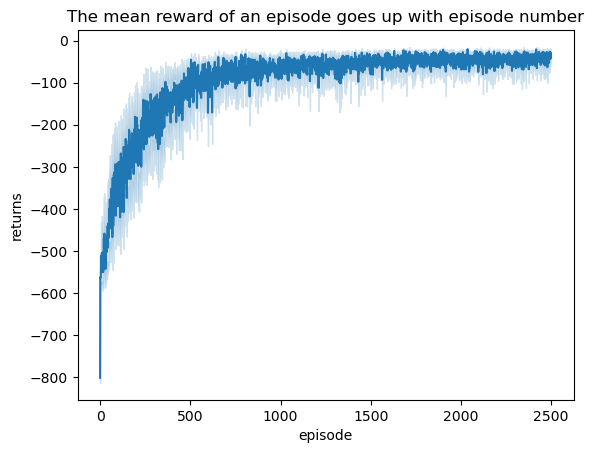

Welp at least there is some indication of learning


In [25]:

df2 = pd.DataFrame(behavior_rewards)
df2.columns.name = 'episode'
df2.index.name = 'learner'
df2 = df2.stack().rename('returns').to_frame()


df3 = pd.DataFrame(target_rewards)
df3.columns.name = 'episode'
df3.index.name = 'learner'
df3 = df3.stack().rename('returns').to_frame()

sns.lineplot( data=df2, x='episode', y='returns');
plt.title('The mean reward of an episode goes up with episode number')
plt.show()
print('Welp at least there is some indication of learning')

                returns                   
                    min median max     IQR
condition                                 
behavior policy    -168  -35.5 -10   53.75
target policy      -508  -15.5 -10  488.25


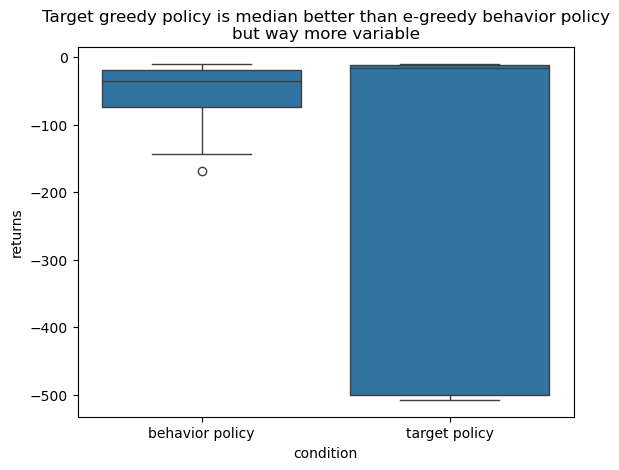

Here's more evidence that the training duration is too short... while target policy is better than the behavior at the median it has some spectacularly bad learners at 2500 episodes


In [29]:
c1 = df2.query('episode==1999').reset_index().drop(columns=['episode'])
c1['condition']='behavior policy'
c2 = df3.droplevel('episode').reset_index()
c2['condition']='target policy'

compare = pd.concat( [c1, c2], ignore_index=True)
sns.boxplot(data=compare, x='condition', y='returns');
plt.title('Target greedy policy is median better than e-greedy behavior policy\nbut way more variable');

print(compare.drop(columns=['learner']).groupby('condition').agg(stats_list))
plt.show()
print('Here\'s more evidence that the training duration is too short... while target policy is better than the behavior at the median it has some spectacularly bad learners at 2500 episodes')

In [10]:
import numpy as np

def plot_track(track, states=None):
    # Get a copy of the course layout and the current position.
    course_layout = track.course.copy()

    if not states:
        states = [np.concatenate(track.get_state())]

    # Set up the figure.
    plt.figure(figsize=(8, 8))
    # Plot the course as a heatmap.
    # Note: We flip the image vertically to match the coordinate system.
    plt.imshow(np.flipud(course_layout.T), cmap="hot", interpolation="nearest")
    plt.title("One episode, marker shows position, arrow shows velocity")

    for astate in states:
        # Transform the current position to match the flipud effect.
        # x coordinate remains the same; y coordinate is flipped.
        s = astate[0]
        
        s1T = course_layout.shape[1] - 1 - s[1]

        # Overlay the current position.
        plt.plot(s[0], s1T, "bo", markersize=10)
        
        plt.arrow(
            s[0],
            s1T,
            s[2],
            -s[3],
            color="cyan",
            head_width=0.2,
            length_includes_head=True,
            zorder=100
        )
    plt.show()

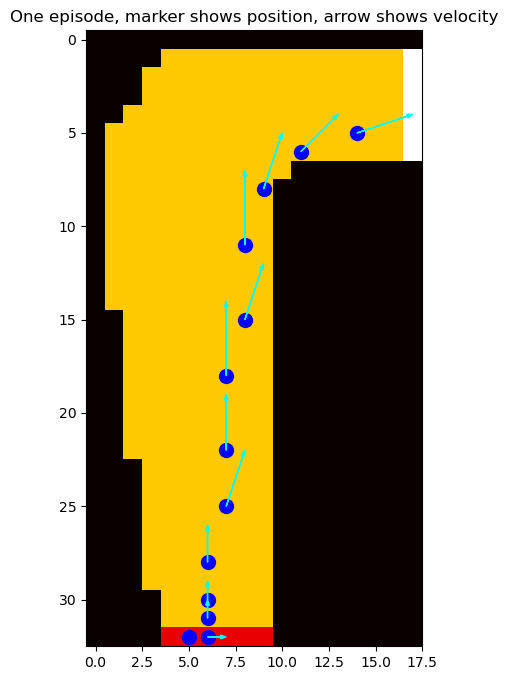

In [40]:
# feel free to use this technique to explore solutions you train!

plot_track(MC.env, episode)

# OK now its your turn...

Pick one of the following:
1. Try to implement on-policy MC on your own.  Test it in the `big_course` setup.  Compare on-policy MC to off-policy MC with similar parameters. 
2. Run at least 10 trials of off-policy MC for enough episodes to get to a much better greedy policy convergence (target policy reward median < 12 and IQR <20)
3. Run at least 10 trials of learning on a new track of your own design (see src/racetrack.py for examples of how to design).  The new track should be 1.2 to 2 times more states than `big_course`.  You will have to go pretty far in the episodes to get a median better than -50 :)  